$$

    f(a) = e^{-\int_0^a{(1+\epsilon(a, s))\mu(s) ds}}\\
    \mu(s) = \mu_{ub} - (\mu_{ub} - \mu_{lb})\frac{s^{m}}{s^{m} + K^{m}}

$$

$$
\epsilon(a, s) = 
\begin{cases}
    0 & \text{if } s < a - t_e \\
    \epsilon_0 e^{-\tau|a-t_e|} e^{-\lambda(t_e-(a-s))} & \text{otherwise }
\end{cases}
$$

In [1]:
from survival_analysis import *
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [ ]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
sector_params_MLE = dict(zip(sector_list, parameters))

In [1]:
from one_tail_dip import *
from hill import *
import matplotlib.pyplot as plt

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.05, 10, 5, find_dip(df_analysis, sector), 3, 1, 0.1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12733144848153208, mu_lb: 0.03886268043032799, K: 13.611463323714604, m: 4.573812739642368, t_e: 8.251443282054064, eps0: 7.468430851666153, tau: 1.566027858800503, lam: 1.5660278588005034
AIC with dip = 395465.44300910877 
 AIC original = 396775.65376669867


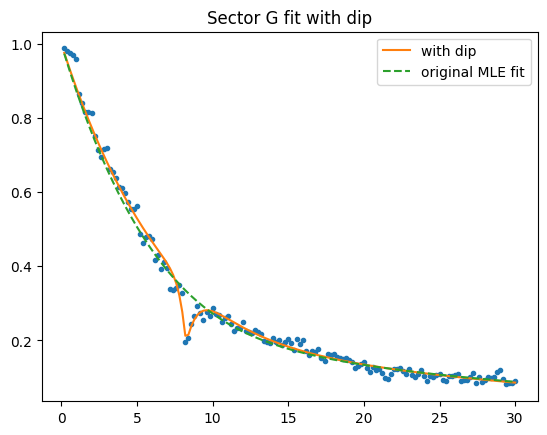

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.10149502069416846, mu_lb: 0.041077986135765056, K: 15.831850421125647, m: 2.2558310877644248, t_e: 6.868957202407013, eps0: 2.0996056035596498, tau: 0.6898589050079502, lam: 1.0000007804328077e-05
AIC with dip = 83395.38232781265 
 AIC original = 85957.7009922323


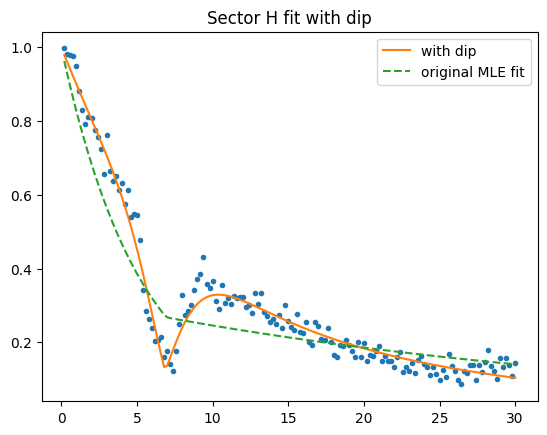

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13543855365938598, mu_lb: 0.010000000000000016, K: 12.953113267490028, m: 6.509328525990969, t_e: 8.268469205235128, eps0: 20.0, tau: 5.003989929204692, lam: 3.1461652946148893
AIC with dip = 71396.08691508233 
 AIC original = 71512.5738700587


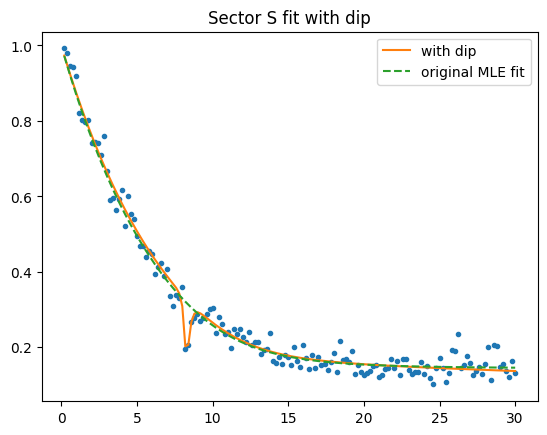

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12383599859390228, mu_lb: 0.05998116813125258, K: 10.715628390019766, m: 19.818541881873937, t_e: 4.551080487534853, eps0: 2.8583000340889737, tau: 2.674875364667751, lam: 0.9462277082914695
AIC with dip = 113661.91006319746 
 AIC original = 113998.28886457565


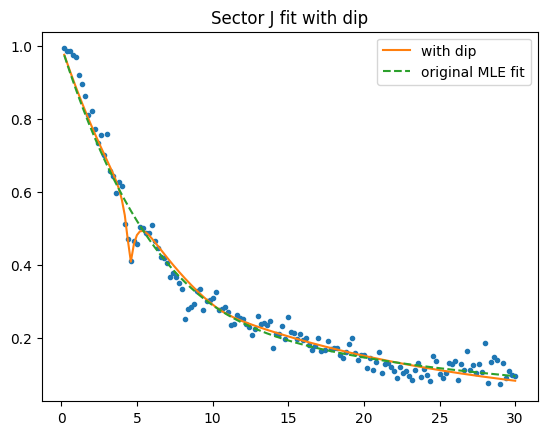

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08778692198482023, mu_lb: 0.010000029768157885, K: 23.167126685264623, m: 10.709413419827682, t_e: 7.699880459620934, eps0: 1.0135001238966077, tau: 0.22226475511579794, lam: 0.2222647872067719
AIC with dip = 213228.71052272708 
 AIC original = 213844.85279567266


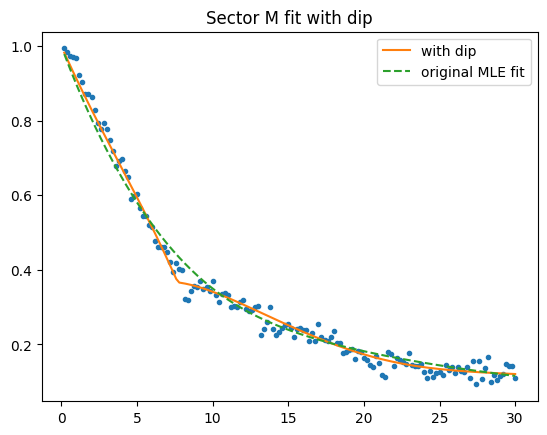

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.12460978893641848, mu_lb: 0.01, K: 20.16508853028377, m: 4.602993101429345, t_e: 5.207488661948977, eps0: 3.6923206299632385, tau: 2.9650472863760515, lam: 2.9650472863760515
AIC with dip = 68491.03462490765 
 AIC original = 68509.00744804495


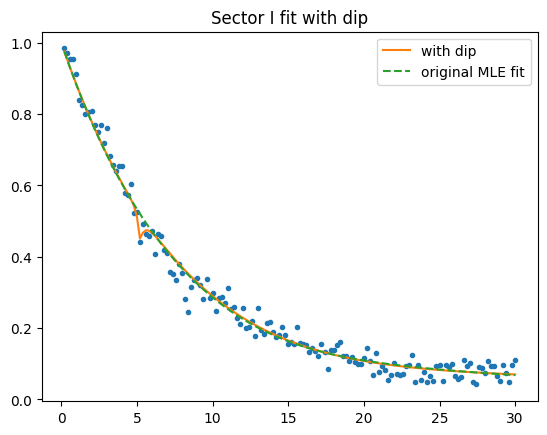

In [21]:
test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    res = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(res[0])
    aic_original_list.append(res[1])    

In [20]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': original_series})
print(aic_df)

    AIC with Dip   AIC Original
G  395465.443009  396775.653767
H   83395.382328   85957.700992
S   71396.086915   71512.573870
J  113661.910063  113998.288865
M  213228.710523  213844.852796
I   68491.034625   68509.007448
